In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Split features and target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [7]:
train_end = int(len(df) * 0.6)

In [8]:
val_end = train_end + int(len(df) * 0.2)

In [9]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [10]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

In [11]:
pipeline

Pipeline(steps=[('encoder_storeid',
                 TargetEncoder(cols=['store_id'],
                               hierarchy=        HIER_store_id_1
0                     1
1                     1
2                     1
3                     3
4                     2
...                 ...
110511                5
110512                4
110513                1
110514                1
110515                2

[110516 rows x 1 columns])),
                ('encoder',
                 TargetEncoder(cols=['market_id', 'store_primary_category',
                                     'order_protocol']))])

In [12]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Hyperparameter tuning

In [13]:
# Objective function
def objective_xgb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 20, log = True)
    gamma = trial.suggest_float("gamma", 5e-5, 0.5, log = True)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    # Create model
    callback_pruner = [optuna.integration.XGBoostPruningCallback(
        trial, "validation_0-mean_squared_error")]
    
    model = XGBRegressor(
        device = "cuda",
        objective = "reg:squarederror",
        callbacks = callback_pruner,
        verbosity = 0,
        random_state = random_state,
        n_estimators = 5000,
        early_stopping_rounds = 50,
        eval_metric = mean_squared_error,
        max_depth = max_depth,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        gamma = gamma,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        subsample = subsample,
        colsample_bytree = colsample_bytree
    )

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train, 
        eval_set = [(X_val, y_val)], 
        verbose = False)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration + 1))
    
    return model.best_score
    

In [14]:
# Create study
study_xgb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_xgb",
  direction = "minimize"
)

[I 2023-11-16 16:15:31,832] A new study created in memory with name: tune_xgb


In [15]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(
  objective_xgb, 
  n_trials = 1000,
  show_progress_bar = True)

Best trial: 498. Best value: 790597: 100%|█████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.40it/s]


In [16]:
# Save tuning log
trials_xgb = study_xgb.trials_dataframe().sort_values("value", ascending = True)
trials_xgb.to_csv("./ModifiedData/trials_xgb.csv", index = False)

# Testing & diagnostics

In [18]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_xgb.csv").iloc[0]

In [19]:
best_tune

number                                                  498
value                                           790597.1875
datetime_start                   2023-11-16 16:17:43.543660
datetime_complete                2023-11-16 16:17:44.232661
duration                             0 days 00:00:00.689001
params_colsample_bytree                              0.5256
params_gamma                                         0.3301
params_l1_reg                                        0.1338
params_l2_reg                                        1.3525
params_learning_rate                                 0.0872
params_max_depth                                          8
params_min_child_weight                                  18
params_subsample                                     0.9394
user_attrs_n_rounds                                 59.0000
system_attrs_completed_rung_0                   805460.0625
system_attrs_completed_rung_1                   793457.6250
system_attrs_completed_rung_2           

In [20]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [23]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [26]:
# Train final model
model = XGBRegressor(
        device = "cuda",
        objective = "reg:squarederror",
        random_state = random_state,
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        max_depth = best_tune["params_max_depth"],
        learning_rate = best_tune["params_learning_rate"],
        min_child_weight = best_tune["params_min_child_weight"],
        gamma = best_tune["params_gamma"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5256269981732478, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3301200987027496,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.087248122000276,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=18, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=59, n_jobs=None,
             num_parallel_tree=None, random_state=1923, ...)

In [27]:
# Make predictions on test data
preds = model.predict(X_test)

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [59]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds
df_pred["actual"] = y_test

In [60]:
# Calculate RMSE
mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False)

1147.8935040621188

In [64]:
# Drop extreme values for visualization?
max_val = max(df_pred["actual"])
#high_val = 12500
#df_pred = df_pred[df_pred["actual"] < high_val]

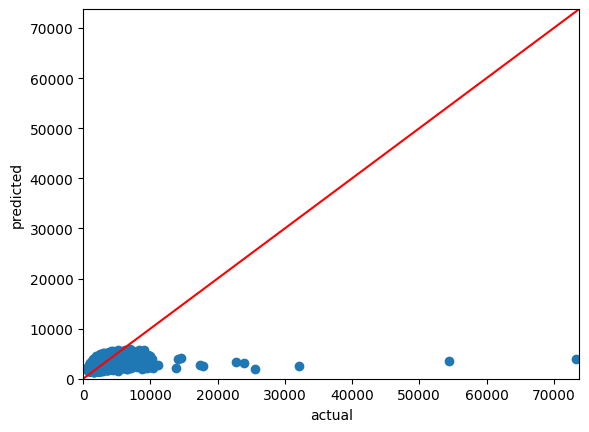

In [65]:
# Plot predicted vs. actual
ax = plt.subplot()
_ = ax.scatter(df_pred["actual"], df_pred["preds"])
_ = ax.plot([0, 1], [0, 1], transform=ax.transAxes, c = "red")
_ = ax.set_xlim(0, max_val + 500)
_ = ax.set_ylim(0, max_val + 500)
_ = ax.set_xlabel("actual")
_ = ax.set_ylabel("predicted")

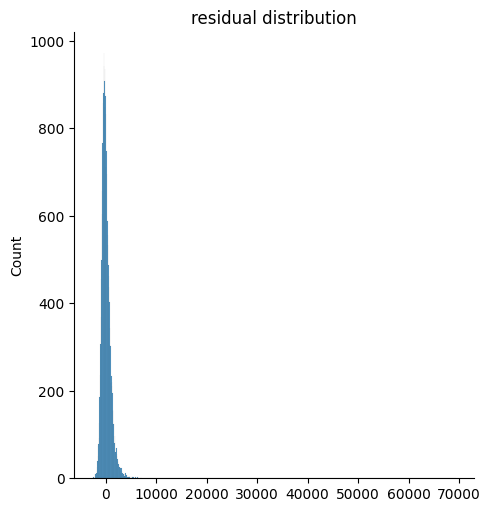

In [66]:
# Residual distribution
_ = sns.displot(df_pred["actual"] - df_pred["preds"])
_ = plt.title("residual distribution")